# Import the necessary libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.utils import save_image

In [ ]:
# Set the device to GPU if available, otherwise use CPU
device = (
    torch.device(f"cuda:{torch.cuda.current_device()}")
    if torch.cuda.is_available()
    else "cpu"
)
torch.set_default_device(device)

# Set the random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# Create custom dataset that combines two images into one
class CombineDataset(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(CombineDataset, self).__init__(root, train, transform, target_transform, download)
        self.data, self.targets = self.combine_images(self.data, self.targets)

    def combine_images(self, data, targets):
        new_data = []
        new_targets = []
        # Combine two random images
        for i in range(len(data) // 2):
            img1 = data[i]
            img2 = data[i + 1]
            new_img = torch.zeros(1, 28, 56)
            new_img[0, :, :28] = img1 / 255.0
            new_img[0, :, 28:] = img2 / 255.0
            new_data.append(new_img)
            new_targets.append(targets[i] * 10 + targets[i + 1])
        # Convert the list to tensor
        new_data = torch.stack(new_data)
        new_targets = torch.tensor(new_targets)
        return new_data, new_targets

    def __getitem__(self, index):
        img, target = self.data[index], int(self.targets[index])
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img, target

    def __len__(self):
        return len(self.data)

# Create a data Loader

In [ ]:
# Create the DataLoader
batch_size = 128
train_dataset = CombineDataset(root="~/Desktop/data", train=True, download=True)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=torch.Generator(device=device),
)

# Show the samples from the data loader

Train dataset length: 30000


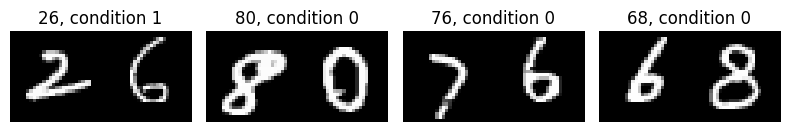

In [ ]:
# Show the length of the dataset
print("Train dataset length:", len(train_dataset))

# Show 4 samples from the DataLoader
data_iter = iter(train_loader)
images, labels = next(data_iter)
fig, axs = plt.subplots(1, 4, figsize=(8, 2))
for i in range(4):
    axs[i].imshow(images[i].squeeze().cpu().detach().numpy(), cmap="gray")
    # Set the title to the label number and the conditional input,
    # 1 if the number is less than 50, 0 otherwise
    axs[i].set_title(f"{labels[i]}, condition {int(labels[i] < 50)}")
    axs[i].axis("off")

# Tight layout
plt.tight_layout()

# Save the figure
plt.savefig("combined_images.png")
plt.show()

# Define Conditional Generator and Conditional critic

In [ ]:
class Generator(nn.Module):
    def __init__(self, noise_dim, condition_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim + condition_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 56),
            nn.Tanh()
        )

    def forward(self, noise, condition):
        x = torch.cat([noise, condition], dim=1)
        x = self.model(x)
        x = x.view(-1, 1, 28, 56)  # Reshape to the image size
        return x

class Critic(nn.Module):
    def __init__(self, condition_dim):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(28 * 56 + condition_dim, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)  # Single output for WGAN score
        )

    def forward(self, img, condition):
        x = img.view(img.size(0), -1)  # Flatten the image
        x = torch.cat([x, condition], dim=1)
        return self.model(x)

# Define Gradient Penalty Function

In [ ]:
def compute_gradient_penalty(critic, real_samples, fake_samples, conditions, device):
    # Random weight for interpolation
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = critic(interpolates, conditions)
    fake = torch.ones(d_interpolates.size()).to(device)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Training Loop for CGAN with WGAN-GP

Epoch [1/30] - Critic Loss: -0.4960, Generator Loss: -0.5353
Epoch [2/30] - Critic Loss: 0.4036, Generator Loss: -1.6148
Epoch [3/30] - Critic Loss: -2.9414, Generator Loss: -0.3945
Epoch [4/30] - Critic Loss: -5.8607, Generator Loss: 0.1391
Epoch [5/30] - Critic Loss: -6.2418, Generator Loss: -1.0010
Epoch [6/30] - Critic Loss: -5.8901, Generator Loss: -0.7875
Epoch [7/30] - Critic Loss: -5.7503, Generator Loss: -0.1844
Epoch [8/30] - Critic Loss: -5.5980, Generator Loss: -0.4058
Epoch [9/30] - Critic Loss: -5.2826, Generator Loss: 0.3296
Epoch [10/30] - Critic Loss: -5.2559, Generator Loss: -0.4927
Epoch [11/30] - Critic Loss: -5.0920, Generator Loss: -0.1099
Epoch [12/30] - Critic Loss: -4.6809, Generator Loss: -0.8260
Epoch [13/30] - Critic Loss: -4.4816, Generator Loss: 0.3525
Epoch [14/30] - Critic Loss: -4.7399, Generator Loss: 2.4477
Epoch [15/30] - Critic Loss: -4.4341, Generator Loss: 1.6213
Epoch [16/30] - Critic Loss: -4.7136, Generator Loss: 3.0014
Epoch [17/30] - Critic L

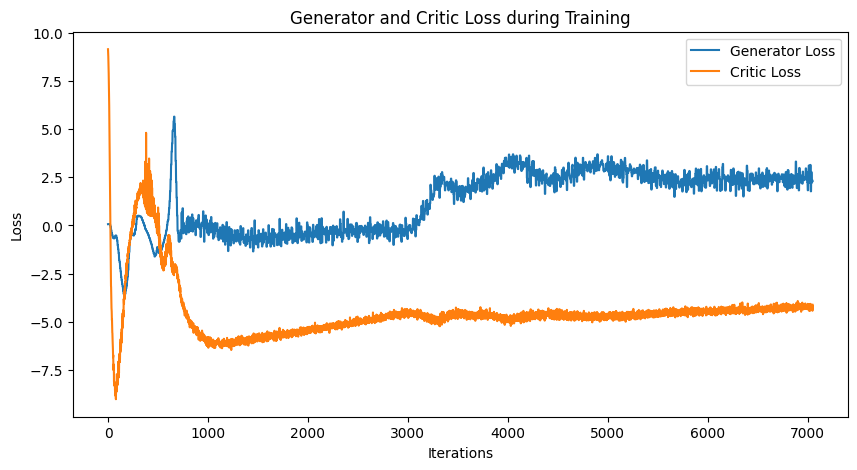

In [ ]:
# Hyperparameters
num_epochs = 30
batch_size = 64
noise_dim = 100
condition_dim = 1
lambda_gp = 10  # Weight for the gradient penalty

# Model initialization
generator = Generator(noise_dim, condition_dim).to(device)
critic = Critic(condition_dim).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.9))
optimizer_C = optim.Adam(critic.parameters(), lr=0.0001, betas=(0.5, 0.9))

# Loss storage for visualization
generator_losses = []
critic_losses = []

for epoch in range(num_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        # Prepare real images and conditions
        real_imgs = imgs.to(device)
        conditions = (labels.view(-1, 1).float() <= 49).float().to(device)

        # Train Critic
        optimizer_C.zero_grad()
        noise = torch.randn(real_imgs.size(0), noise_dim).to(device)
        fake_imgs = generator(noise, conditions)

        real_validity = critic(real_imgs, conditions)
        fake_validity = critic(fake_imgs.detach(), conditions)
        gradient_penalty = compute_gradient_penalty(critic, real_imgs, fake_imgs, conditions, device)

        loss_C = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty
        loss_C.backward()
        optimizer_C.step()

        # Train Generator every 5 iterations
        if i % 5 == 0:
            optimizer_G.zero_grad()
            gen_imgs = generator(noise, conditions)
            loss_G = -torch.mean(critic(gen_imgs, conditions))
            loss_G.backward()
            optimizer_G.step()

        # Store losses for visualization
        critic_losses.append(loss_C.item())
        generator_losses.append(loss_G.item())

    print(f"Epoch [{epoch+1}/{num_epochs}] - Critic Loss: {loss_C.item():.4f}, Generator Loss: {loss_G.item():.4f}")

# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(generator_losses, label="Generator Loss")
plt.plot(critic_losses, label="Critic Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Generator and Critic Loss during Training")
plt.legend()
plt.show()

# Generate and Visualize the samples

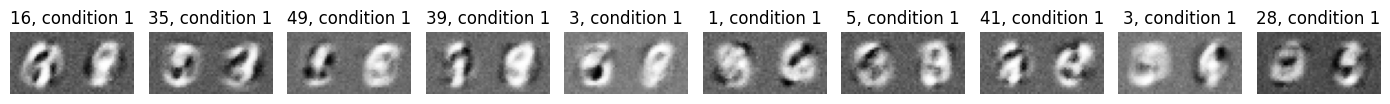

In [ ]:
# Define a function to generate samples
def generate_samples(generator, num_samples, noise_dim, condition, device):
    generator.eval()
    z = torch.randn(num_samples, noise_dim).to(device)
    condition_tensor = torch.full((num_samples, 1), condition, dtype=torch.float32).to(device)
    with torch.no_grad():
        generated_imgs = generator(z, condition_tensor).cpu()
    return generated_imgs

# Generate and plot 10 samples with condition = 1 (<= 49)
num_samples = 10
noise_dim = 100
condition = 1

# Generate the images and corresponding random labels <= 49
generated_images = generate_samples(generator, num_samples, noise_dim, condition, device)

# Here, we generate labels randomly as an example
labels = np.random.randint(0, 50, size=num_samples).reshape(-1, 1)

# Create a plot with 10 subplots
fig, axs = plt.subplots(1, num_samples, figsize=(14, 2))

# Plot each generated image and set titles accordingly
for i in range(num_samples):
    img = generated_images[i].squeeze().detach().cpu().numpy()

    # Display the generated image
    axs[i].imshow(img, cmap="gray")

    # Set the title to indicate the generated number and conditional input
    # e.g., "34, condition 1"
    axs[i].set_title(f"{int(labels[i][0])}, condition {int(labels[i][0] < 50)}")
    axs[i].axis("off")

# Tight layout for better appearance
plt.tight_layout()

# Save the figure
plt.savefig("combined_images.png")
plt.show()